In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk

In [2]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [3]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

C:\Users\atuteja\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

C:\Users\atuteja\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\atuteja\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [4]:
# Read in data
df = pd.read_csv('input/Reviews.csv')
df = df.head(2000)

In [5]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

<Axes: title={'center': 'Count of Reviews'}, xlabel='Score'>

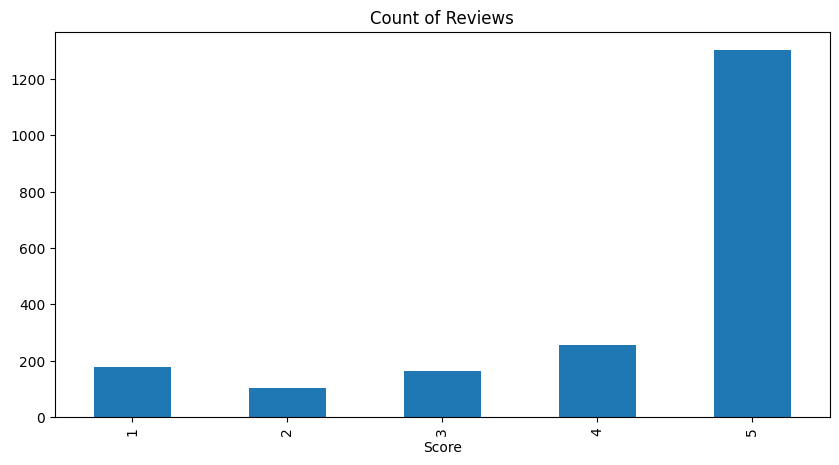

In [6]:
df['Score'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews', figsize=(10,5))

In [12]:
example = df['Text'][1045]
example

'i bought the liter size bottles of this dressing on Amazon, so i am assuming they are the same since they have the same name and the nutritional facts are identical. This dressing is definitely too sweet for my taste. My wife agrees. Otherwise very good. I use it on tossed salads only.'

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [10]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'compound': 0.8858}

In [11]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'Negative' : scores[0],
    'Neutral' : scores[1],
    'Positive' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0108445445, 'roberta_neu': 0.08204518, 'roberta_pos': 0.9071102}


In [25]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'Negative' : scores[0],
        'Neutral' : scores[1],
        'Positive' : scores[2]
    }
    return scores_dict

In [18]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

<BarContainer object of 3 artists>

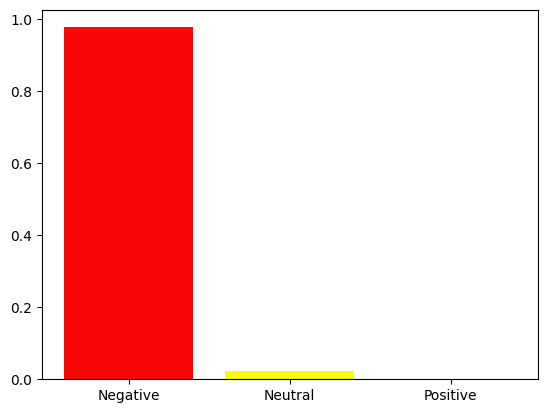

In [45]:
sentance = "My eicher doesn't work properly, i don't want the subscription"

score = polarity_scores_roberta(sentance)
fig, ax = plt.subplots()
ax.bar(score.keys(), score.values(), color=['#F90707', '#FBFB08', '#3BCD76'])
